In [44]:
#import all the necessary library used in this project

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc
from sklearn.manifold import TSNE

import joblib

from typing import Dict, Optional, List , Tuple
from numbers import Number

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi':150})

In [53]:
# Load the dataset from the csv file using pandas
data = pd.read_csv("creditcard.csv").drop('Time' , axis=1)
# Grab a peek at the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [59]:
# Print the shape of the data
# data = data.sample(frac = 0.1, random_state = 48)
print(f'Number of observations: {data.shape[0]}')
print(data.describe())

Number of observations: 284807
                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15  2.239053e-15   
std    1.332271e+00 

In [55]:
neg , pos = np.bincount(data['Class'])
total = neg + pos
print(f'Number of positive observations: {pos} ({100*pos / total:.2f}% of total)')

Number of positive observations: 492 (0.17% of total)


In [56]:
#Generating Training
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1, stratify=data['Class'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2, stratify=train_df['Class'])

In [57]:
#Genarating Validation
y_train = train_df.pop('Class').values
y_val = val_df.pop('Class').values
y_test = test_df.pop('Class').values

In [58]:
#Generating Test Split
for tag, labels in zip(['training', 'validation', 'test'], [y_train, y_val, y_test]):
    print(f'Percentage of positive class observations in {tag} set: {labels.mean()*100:.3f}')

Percentage of positive class observations in training set: 0.173
Percentage of positive class observations in validation set: 0.173
Percentage of positive class observations in test set: 0.172


In [60]:
# Determine number of fraud cases in dataset
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
outlierFraction = len(fraud)/float(len(valid))
print(outlierFraction)
print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [62]:
print("details of valid transaction")
valid.Amount.describe()

details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

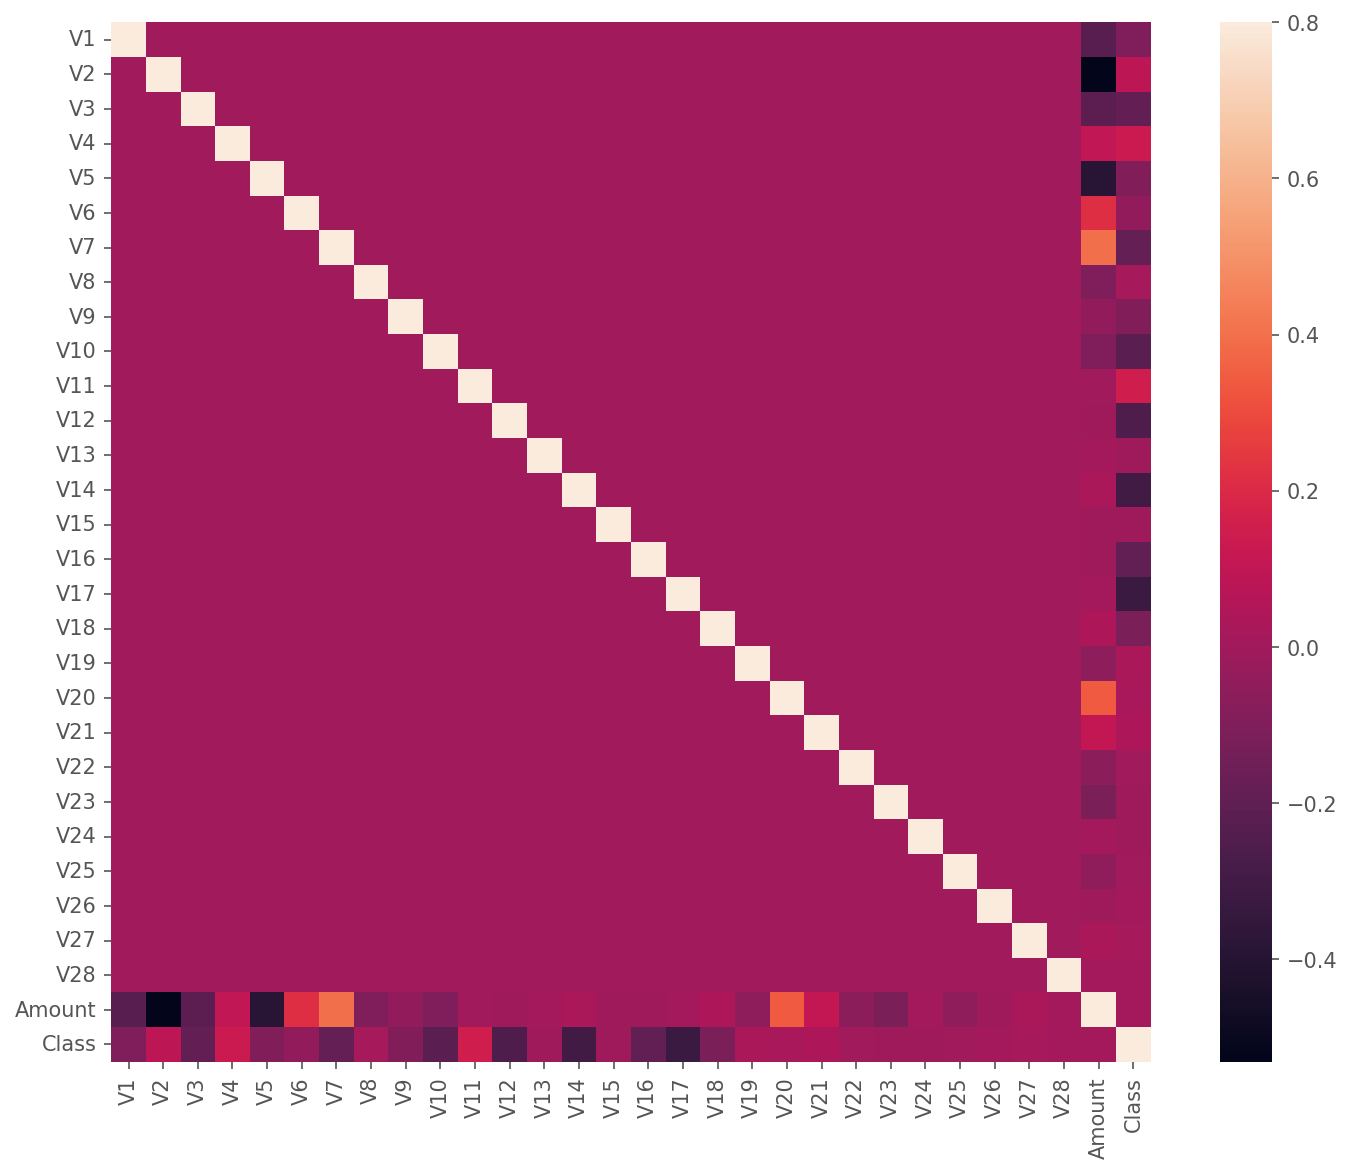

In [63]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [64]:
# dividing the X and the Y from the dataset
X = data.drop(['Class'], axis = 1)
Y = data["Class"]
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing
# (its a numpy array with no columns)
xData = X.values
yData = Y.values

(284807, 29)
(284807,)


In [65]:
xTrain, xTest, yTrain, yTest = train_test_split(
        xData, yData, test_size = 0.2, random_state = 42)

In [66]:
# Building the Random Forest Classifier (RANDOM FOREST)
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(xTrain, yTrain)
# predictions
yPred = rfc.predict(xTest)

In [67]:
# Evaluating the classifier
# printing every score of the classifier
# scoring in anything
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

n_outliers = len(fraud)
n_errors = (yPred != yTest).sum()
print("The model used is Random Forest classifier")

acc = accuracy_score(yTest, yPred)
print("The accuracy is {}".format(acc))

prec = precision_score(yTest, yPred)
print("The precision is {}".format(prec))

rec = recall_score(yTest, yPred)
print("The recall is {}".format(rec))

f1 = f1_score(yTest, yPred)
print("The F1-Score is {}".format(f1))

MCC = matthews_corrcoef(yTest, yPred)
print("The Matthews correlation coefficient is{}".format(MCC))


The model used is Random Forest classifier
The accuracy is 0.9995962220427653
The precision is 0.9629629629629629
The recall is 0.7959183673469388
The F1-Score is 0.871508379888268
The Matthews correlation coefficient is0.8752766822621103


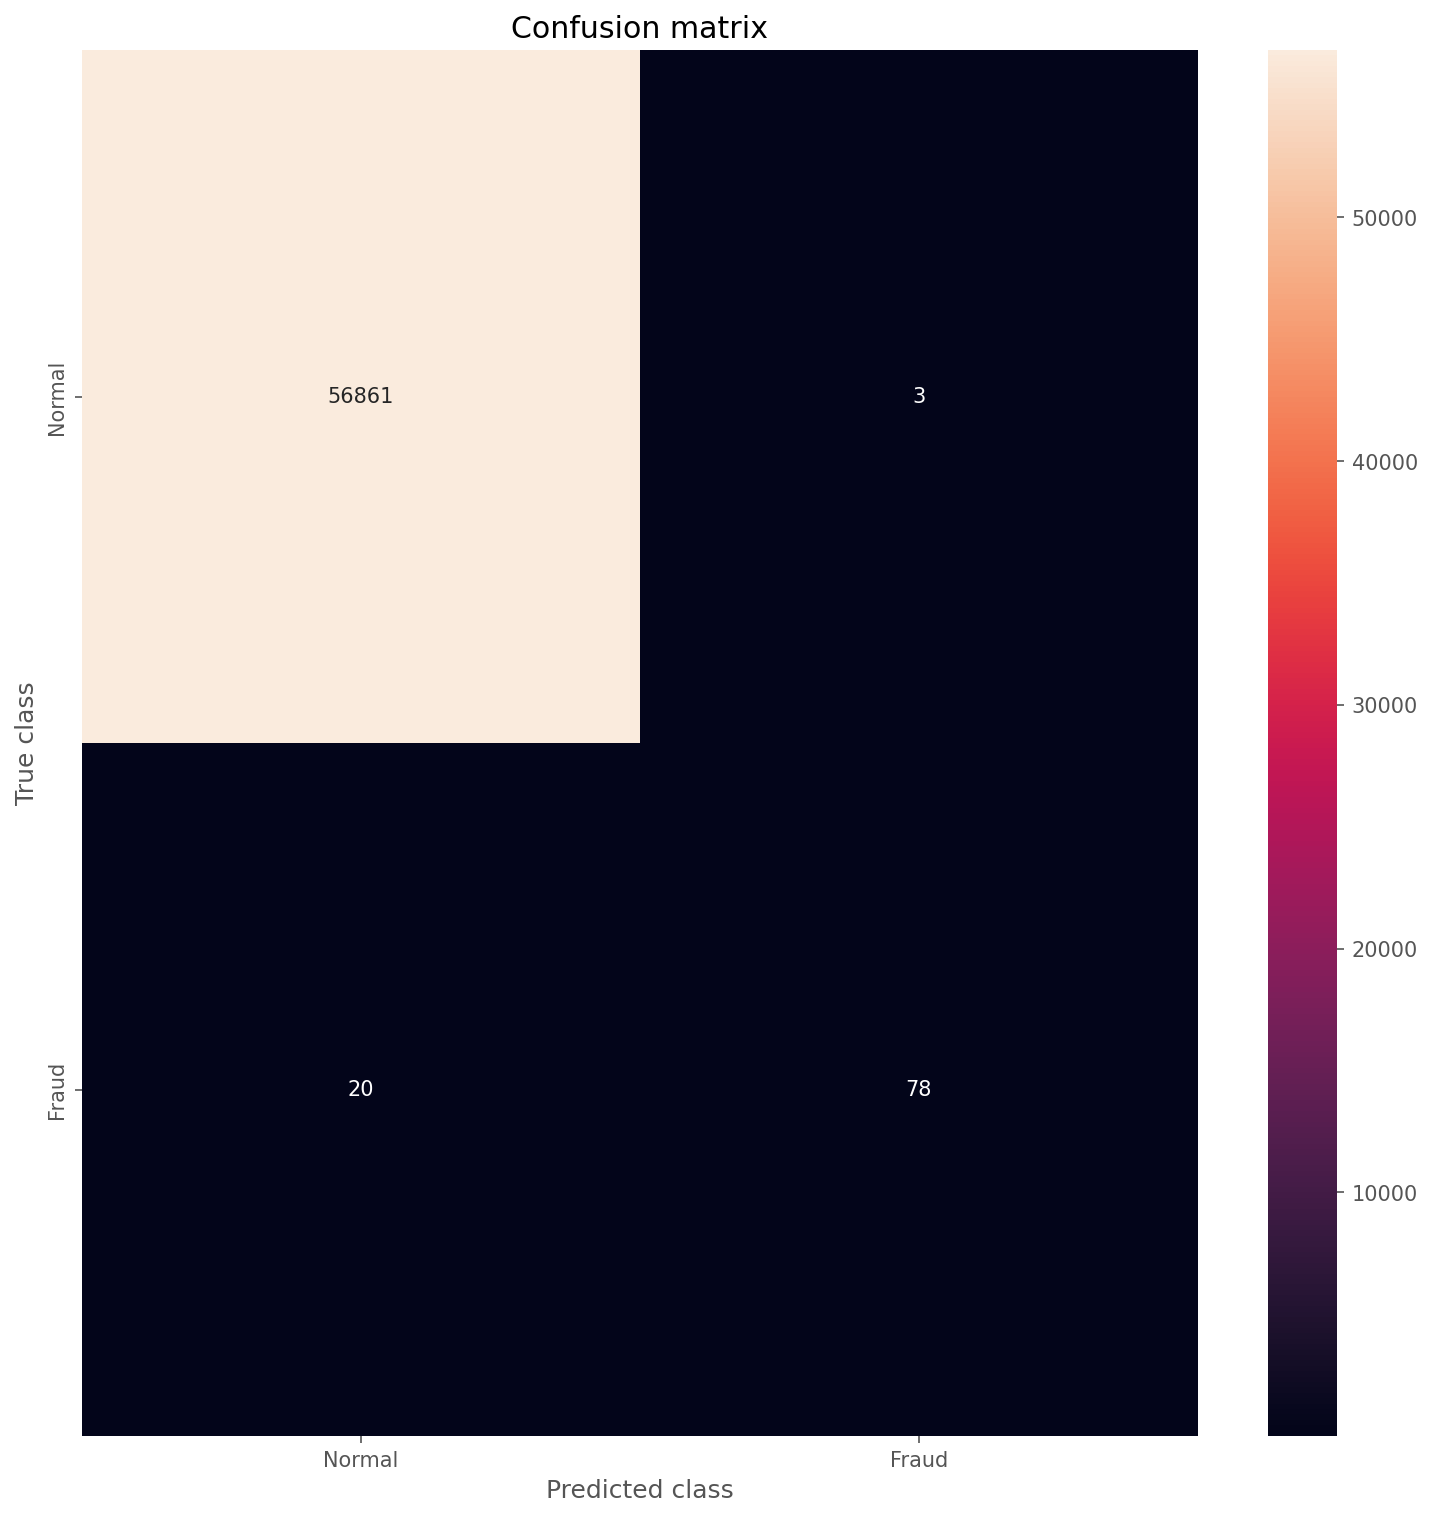

In [68]:
# printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize =(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS,
			yticklabels = LABELS, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
